## plotNWT_hillslope_simple _KJ_ additions of observations
#### Plots results from hillslope simulation
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 28, 2021

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

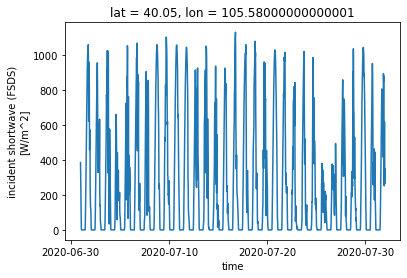

In [90]:
din = ['/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/moist_meadow2020/']
fin = [din[0] + '2020-07.nc']  
ds = utils.time_set_mid(xr.open_mfdataset(fin, decode_times=True, combine='by_coords'), 'time').load()
ds = ds.isel(lat=0,lon=0)
ds.FSDS.plot() ;

In [91]:
ds[Var[0]]

<xarray.DataArray 'FSDS' (time: 1488)>
array([385.3 , 283.27, 181.9 , ..., 618.53, 262.49, 350.06])
Coordinates:
    lat      float64 40.05
    lon      float64 105.6
  * time     (time) object 2020-07-01 00:00:00 ... 2020-07-31 23:30:00
Attributes:
    units:      W/m^2
    long_name:  incident shortwave (FSDS)
    mode:       time-dependent

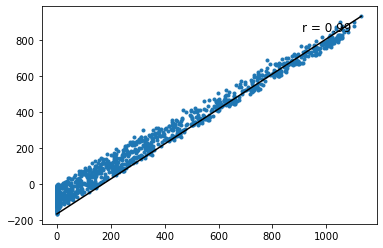

In [92]:
Var = ['FSDS','TBOT','Rnet']
fig, ax = plt.subplots()
x, y = ds[Var[0]].values,  ds[Var[2]].values

ax.plot(x, y,'.')
line = mlines.Line2D([x.min(), x.max()], [y.min(), y.max()], color='k')
ax.add_line(line)
#ax.text(0.15, 0.90,(Var[0]+', ', fontsize=14, 
#        ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, 
        ha='center', va='center', transform=plt.gca().transAxes);

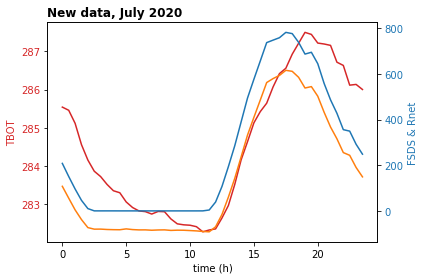

In [94]:
ds['HourMin'] = np.round(ds['time.hour'] + ds['time.minute']/60,1)
rollHour = -12 

diel = ds.groupby(ds['HourMin']).mean()#.roll(HourMin=rollHour, roll_coords=False)
dielSD = ds.groupby(ds['HourMin']).std()#.roll(HourMin=rollHour, roll_coords=False)
x = diel.HourMin

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (h)')
ax1.set_ylabel('TBOT', color=color)
ax1.plot(x, diel[Var[1]], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('FSDS & Rnet', color=color)  # we already handled the x-label with ax1
ax2.plot(x, diel[Var[0]], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
#ax3.set_ylabel(Var[2], color=color)  # we already handled the x-label with ax1
ax2.plot(x, diel[Var[2]], color=color)
#ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('New data, July 2020',  loc='left', fontsize='large', fontweight='bold')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='3:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

In [4]:
cluster

### Point to files

In [5]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
site  = ['DM','MM']
longSite  =  ['dry meadow','moist meadow']#'dry_meadow'
#case  =  ['NEON_NIWO_hh_test']
#case  =  ['NEON_NIWO_3col_dm01_newSoil_trans','NEON_NIWO_3col_mm01_newSoil_trans']
case  =  ['NEON_NIWO_3col_dm01f','NEON_NIWO_3col_mm02h']
#case  =  ['NEON_NIWO_3col','NEON_NIWO_3col_flatSoil']
rollHour = -12  
years = range(2018,2019)
nmon  = 12

dirIn = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]
# dirIn = ['/glade/scratch/wwieder/'+case[c]+'/run/' for c in range(len(case))]
dmfiles = [dirIn[0] + case[0] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
mmfiles = [dirIn[1] + case[1] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
print(dmfiles[0])
print(mmfiles[0])

/glade/scratch/wwieder/archive/NEON_NIWO_3col_dm01f/lnd/hist/NEON_NIWO_3col_dm01f.clm2.h1.2018-01-01-00000.nc
/glade/scratch/wwieder/archive/NEON_NIWO_3col_mm02h/lnd/hist/NEON_NIWO_3col_mm02h.clm2.h1.2018-01-01-00000.nc


--- 
### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [6]:
%%time
ds_dm = utils.time_set_mid(xr.open_mfdataset(dmfiles, decode_times=True, combine='by_coords'), 'time').load()
ds_mm = utils.time_set_mid(xr.open_mfdataset(mmfiles, decode_times=True, combine='by_coords'), 'time').load()
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 2.09 s, sys: 223 ms, total: 2.31 s
Wall time: 8.78 s


NEON_NIWO_3col_dm01f
[  0.          0.        190.5269095]
NEON_NIWO_3col_mm02h
[422.24487767 617.59873753 645.53764582]


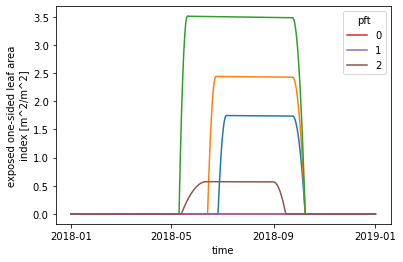

In [7]:
print(case[0])
print((ds_dm.GPP.mean('time')*(365*24*3600)).values)
print(case[1])
print((ds_mm.GPP.mean('time')*(365*24*3600)).values)
ds_mm.ELAI.plot(hue='pft')#.where(ds_mm.time['time.year']==2018).plot(hue='pft')
ds_dm.ELAI.plot(hue='pft') ;#.where(ds_dm.time['time.year']==2018).plot(hue='pft');
#ds_mm.ELAI.plot(hue='pft');

#### Combine pft and column coordinates
#### Then combine datasets 

In [12]:
# Combine datasets
ds_dm = ds_dm.rename({'pft':'column'})
ds_mm = ds_mm.rename({'pft':'column'})
ds  = ds_dm.where(ds_dm.column==2, ds_mm)

# just use mm simulations
# ds = ds_dm
#ds = ds.rename({'pft':'column'})
ds = ds.assign_coords({"column": ["Moist", "Wet", "Dry"]})

### Sample surface dataset has 
- all columns have arctic C3 grass
- not sure what `hslp_cold` is about, but it seems to have missing values for the highest elevation columns.  Also, lateral flow is more regular from these columns (see plot below)

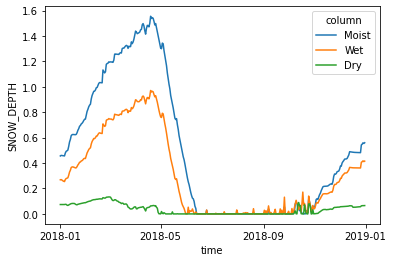

In [13]:
dsPlot = ds.where(ds.time['time.year']==2018).resample(time='D').mean('time')
dsPlot = dsPlot.load()
dsPlot.SNOW_DEPTH.plot(hue='column') ;

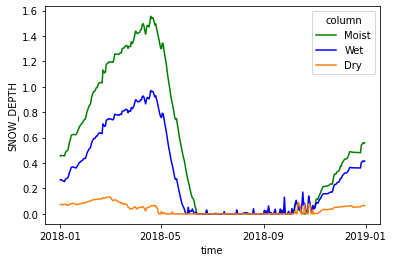

In [23]:
from cycler import cycler
colorlist = ['green', 'blue', 'tab:orange']
cmap = mcolors.ListedColormap(colorlist)
custom_cycler = cycler(color=cmap.colors) #or simply color=colorlist

fig = plt.figure()
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)

dsPlot.SNOW_DEPTH.plot(hue='column',ax=ax) ;

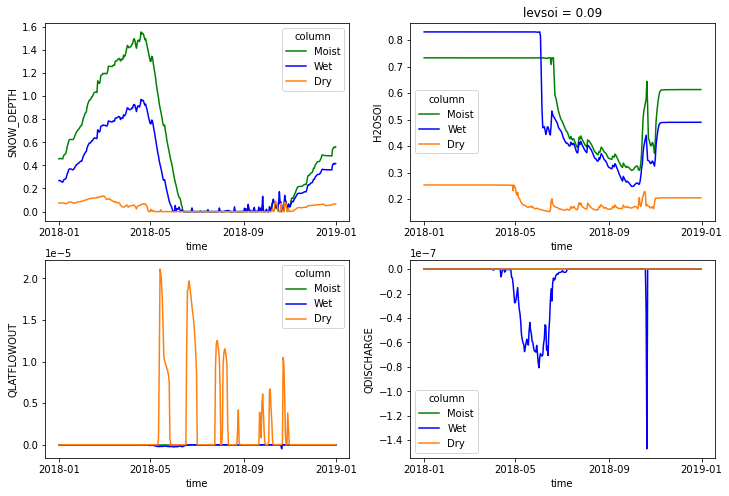

In [29]:
fig = plt.figure(figsize=[12,8])

plt.subplot(221)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
dsPlot.SNOW_DEPTH.plot(hue='column',ax=ax) 
plt.subplot(222)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
dsPlot.isel(levsoi=2).H2OSOI.plot(hue='column',ax=ax);

plt.subplot(223)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
dsPlot.QLATFLOWOUT.plot(hue='column',ax=ax) ;

plt.subplot(224)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
dsPlot.QDISCHARGE.plot(hue='column',ax=ax) ;


Text(0, 0.5, 'Leaf area index (m2/m2)')

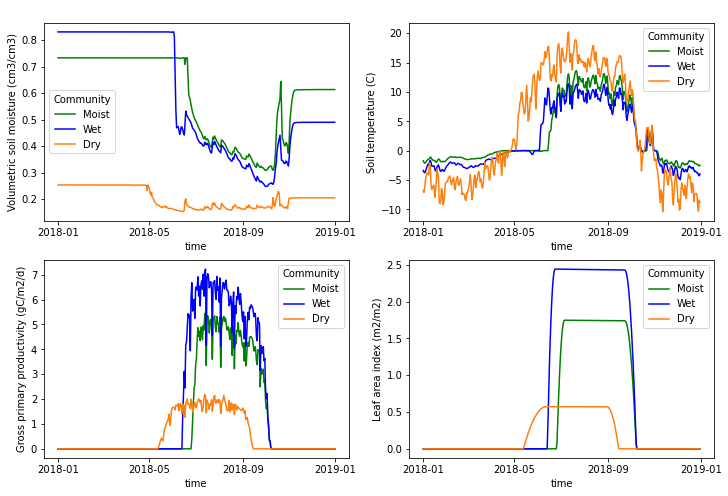

In [65]:
dsPlot2 = dsPlot.rename({'column':'Community'})
plt.figure(figsize=[12,8])

plt.subplot(221)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
dsPlot2.isel(levsoi=2).H2OSOI.plot(hue='Community')
plt.ylabel("Volumetric soil moisture (cm3/cm3)")
plt.title(" ")
#plt.title("CLM5 simulations configured for Saddle communities at NWT",loc='left')

plt.subplot(222)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
(dsPlot2.isel(levgrnd=2).TSOI-273.15).plot(hue='Community');
plt.ylabel("Soil temperature (C)")
plt.title(" ")

plt.subplot(223)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
(dsPlot2.GPP*24*3600).plot(hue='Community') ; #gC/m2/d
plt.ylabel("Gross primary productivity (gC/m2/d)")

plt.subplot(224)
ax = plt.gca()
ax.set_prop_cycle(custom_cycler)
dsPlot2.ELAI.plot(hue='Community')
plt.ylabel("Leaf area index (m2/m2)")


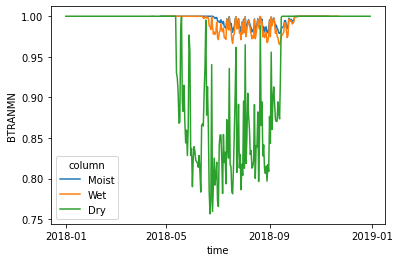

In [37]:
dsPlot.BTRANMN.where(dsPlot.BTRANMN>0).plot(hue='column') ; #.plot(hue='pft');


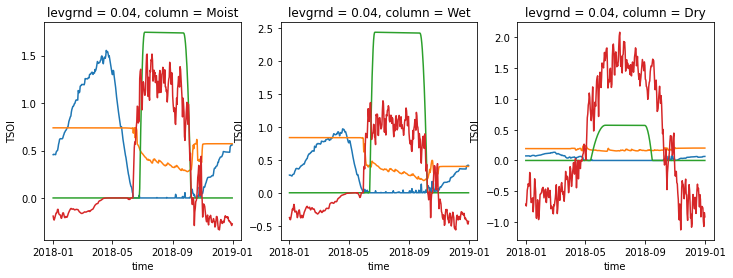

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True,figsize=[12,4])
for i in range(len(ds.column)):
    plt.subplot(1,3,(i+1))
    dsPlot.SNOW_DEPTH.isel(column=i).plot()
    dsPlot.isel(levsoi=1,column=i).H2OSOI.plot()
    dsPlot.ELAI.isel(column=i).plot()
    ((dsPlot.isel(levgrnd=1,column=i).TSOI-273.15)/10).plot()

gC/m^2/s


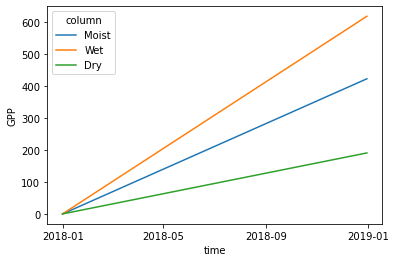

In [39]:
print(ds.GPP.attrs['units'])
(ds.GPP.resample(time='Y').mean('time')*365*24*3600).plot(hue='column') ;

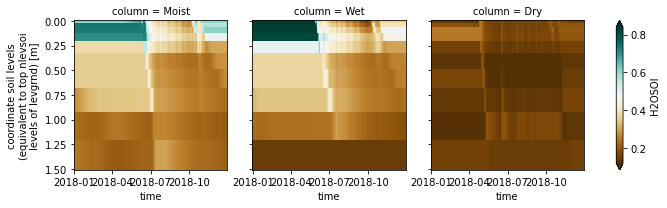

In [40]:
g_simple = dsPlot.H2OSOI.isel(levsoi=slice(0,10),time=slice(0,365)).plot(
    x="time", y="levsoi", col="column", yincrease=False, 
    cmap=plt.cm.BrBG,col_wrap=3, robust=True)

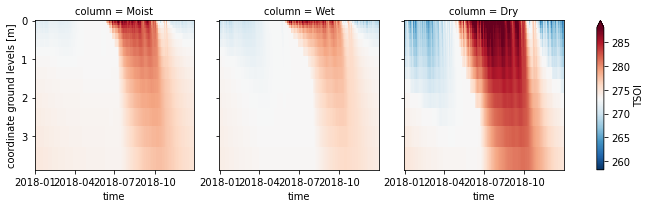

In [41]:
g_simple = dsPlot.isel(levgrnd=slice(0,15),time=slice(0,365)).TSOI.plot(
    x="time", y="levgrnd", col="column", center=273.15, yincrease=False,
    col_wrap=3, robust=True)

In [42]:
# ds

In [43]:
ds['NPP'] = ds.GPP - ds.AR

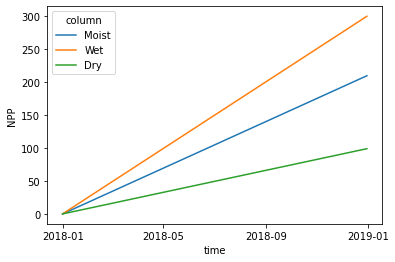

In [44]:
(ds.NPP.resample(time='Y').mean('time')*365*24*3600).plot(hue='column');

## Reading in observations to compare with simulations

In [45]:
nwtOBS = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/NWT_lter_obs_downloads/'
dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = pd.read_table(nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt') # Saddle snow 
dsNPP = pd.read_table(nwtOBS+'saddle_grid_productivity_data.txt')    # Saddle productivity

# add date-time
dsNET.date = pd.to_datetime(dsNET.date)
dsTVan.date = pd.to_datetime(dsTVan.date)
dsSNO.date = pd.to_datetime(dsSNO.date)
#dsNPP.date = pd.to_datetime(dsNPP.date)

# combine sensor data from saddle network and Tvan
dsSOI = pd.concat([dsNET,dsTVan]) 

In [46]:
# Aggregate data by date & vegetation community 
# This is already done for snowdepth
dsSOIgroup = dsSOI.groupby(['date','veg_com'])
dsSOIdaily = dsSOIgroup.aggregate(np.mean)
dsSOIdailySTD = dsSOIgroup.aggregate(np.std)

# This is already done for snowdepth, but now we'll get results dimensioned by date*veg_com
dsSNOgroup = dsSNO.groupby(['date','veg_com'])
dsSNOdaily = dsSNOgroup.aggregate(np.mean)

dsNPPgroup = dsNPP.groupby(['year','veg_com'])
dsNPPdaily = dsNPPgroup.aggregate(np.mean)
dsNPPdailySTD = dsNPPgroup.aggregate(np.std)

In [47]:
## Converting Saddle network data to xarray

In [48]:
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()

# reindex by veg community for plotting consistency
Veg = ["DM", "MM","WM"]
fullVeg = ["dry_meadow", "moist_meadow","wet_meadow"]
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

veg  = ["dm","mm","wm"]
ds = ds.reindex({'column': veg})

In [49]:
## Quick plots

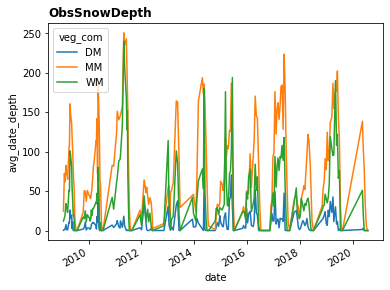

In [50]:
# Snow depth
dsSNO.where(dsSNO['date.year']>2008).avg_date_depth.plot(hue='veg_com');
plt.title('ObsSnowDepth', loc='left', fontsize='large', fontweight='bold');

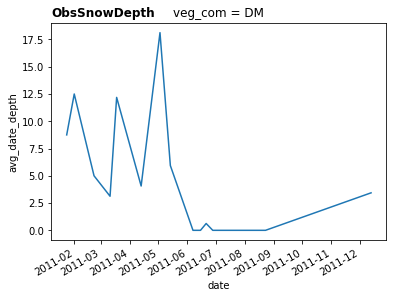

In [51]:
dsSNO.sel(veg_com='DM').where(dsSNO['date.year']==2011).avg_date_depth.plot();
plt.title('ObsSnowDepth', loc='left', fontsize='large', fontweight='bold');

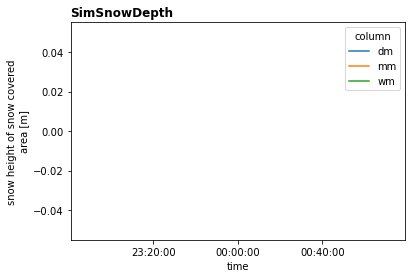

In [52]:
ds.SNOW_DEPTH.plot(hue='column') ;
plt.title('SimSnowDepth', loc='left', fontsize='large', fontweight='bold');

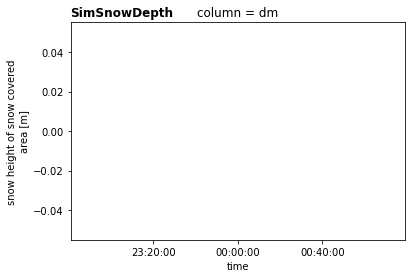

In [53]:
ds.sel(column='dm').SNOW_DEPTH.plot() ;
plt.title('SimSnowDepth', loc='left', fontsize='large', fontweight='bold');

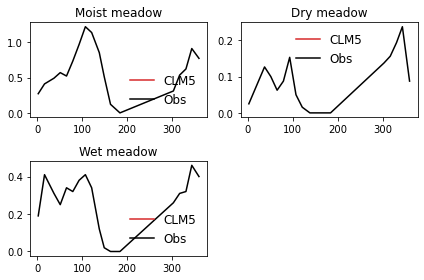

In [54]:
plotYear =  2018
com_sim = 'mm'
com_obs = 'MM'

x = ds['time.dayofyear'].where(ds['time.year']==plotYear)
y = ds.sel(column='mm').where(ds['time.year']==plotYear).SNOW_DEPTH

x2 = dsSNO['date.dayofyear'].where(dsSNO['date.year']==plotYear)
y2 = dsSNO.sel(veg_com='MM').where(dsSNO['date.year']==plotYear).avg_date_depth/100

x3 = ds['time.dayofyear'].where(ds['time.year']==plotYear)
y3 = ds.sel(column='dm').where(ds['time.year']==plotYear).SNOW_DEPTH

x4 = dsSNO['date.dayofyear'].where(dsSNO['date.year']==plotYear)
y4 = dsSNO.sel(veg_com='DM').where(dsSNO['date.year']==plotYear).avg_date_depth/100

x5 = ds['time.dayofyear'].where(ds['time.year']==plotYear)
y5 = ds.sel(column='wm').where(ds['time.year']==plotYear).SNOW_DEPTH

x6 = dsSNO['date.dayofyear'].where(dsSNO['date.year']==plotYear)
y6 = dsSNO.sel(veg_com='WM').where(dsSNO['date.year']==plotYear).avg_date_depth/100

fig, axs = plt.subplots(2, 2)

axs[0,0].plot(x, y, color='tab:red')
axs[0,0].plot(x2, y2, color='black')
axs[0,0].set_title("Moist meadow")
axs[0,1].plot(x3, y3, color='tab:red')
axs[0,1].plot(x4, y4, color='black')
axs[0,1].set_title("Dry meadow")
axs[1,0].plot(x5, y5, color='tab:red')
axs[1,0].plot(x6, y6, color='black')
axs[1,0].set_title("Wet meadow")

#ax.plot(x, y, color='tab:red')
#ax.plot(x2, y2, color='black')
axs[0,0].legend(('CLM5','Obs'), frameon=False,fontsize='large')
axs[0,1].legend(('CLM5','Obs'), frameon=False,fontsize='large')
axs[1,0].legend(('CLM5','Obs'), frameon=False,fontsize='large')

axs.flat[-1].set_visible(False)
fig.tight_layout()
plt.show()

In [55]:
ds

<xarray.Dataset>
Dimensions:             (column: 3, gridcell: 1, hist_interval: 2, landunit: 1, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, time: 17520)
Coordinates:
  * column              (column) <U2 'dm' 'mm' 'wm'
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * time                (time) object 2017-12-31 23:44:59.999993 ... 2018-12-...
Dimensions without coordinates: gridcell, hist_interval, landunit, lndgrid
Data variables: (12/86)
    hslp_distance       (column) float64 nan nan nan
    hslp_width          (column) float64 nan nan nan
    hslp_area           (column) float64 nan nan nan
    hslp_elev           (column) float64 nan nan nan
    hslp_slope          (column) float64 nan nan nan
    hslp_aspect         (column) float64 nan nan nan
    ...                  ...
    SNOW_DEPTH          (time, column) float32 nan nan nan nan ... nan nan nan
    SOILC_vr            (time, levsoi, column) float32 nan nan nan ... nan nan
    TBOT                (time, column) float32 nan nan nan nan ... nan nan nan
    TSOI                (time, levgrnd, column) float32 nan nan nan ... nan nan
    TV                  (time, column) float32 nan nan nan nan ... nan nan nan
    NPP                 (time, column) float32 nan nan nan nan ... nan nan nan
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 11/11/21 06:09:31
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./NEON_NIWO_3col_dm01f.clm2.h0.2008...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

[nan nan]


AttributeError: 'DataArrayResample' object has no attribute 'calendar'

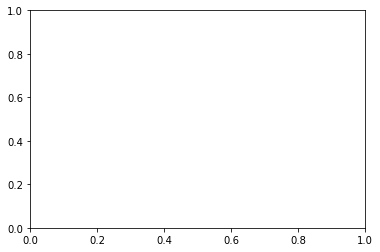

In [56]:
#ds.NPP.resample(time='Y').mean('time').plot(hue='column');
plotYear =  2018
com_sim = 'mm'
com_obs = 'MM'

x = ds['time.dayofyear'].where(ds['time.year']==plotYear).resample(time='Y')
y = ds.sel(column=com_sim).where(ds['time.year']==plotYear).resample(time='Y').mean('time').AGNPP
print(y.values)
x2 = dsNPP['year'].where(dsNPP['year']==plotYear)
y2 = dsNPP.sel(veg_com=com_obs).where(dsNPP['year']==plotYear).NPP
#y2STD = dsSNOstd[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)

fig, ax = plt.subplots()

ax.plot(x, y, color='tab:red')
ax.plot(x2, y2, color='black')
ax.legend(('CLM5','Obs'), frameon=False,fontsize='large')
plt.show()

In [57]:
dsNPP

<xarray.Dataset>
Dimensions:         (veg_com: 3, year: 16)
Coordinates:
  * veg_com         (veg_com) <U2 'DM' 'MM' 'WM'
  * year            (year) int64 1992 1993 1994 1995 ... 2016 2017 2018 2019
Data variables:
    grid_pt         (year, veg_com) float64 nan 44.72 51.2 ... 219.7 44.69 51.2
    subsample_none  (year, veg_com) float64 nan 199.8 149.4 nan ... nan nan nan
    subsample_A     (year, veg_com) float64 nan nan nan ... 141.3 216.4 192.0
    subsample_B     (year, veg_com) float64 nan nan nan nan ... nan nan nan
    NPP             (year, veg_com) float64 nan 199.8 149.4 ... 216.4 192.0

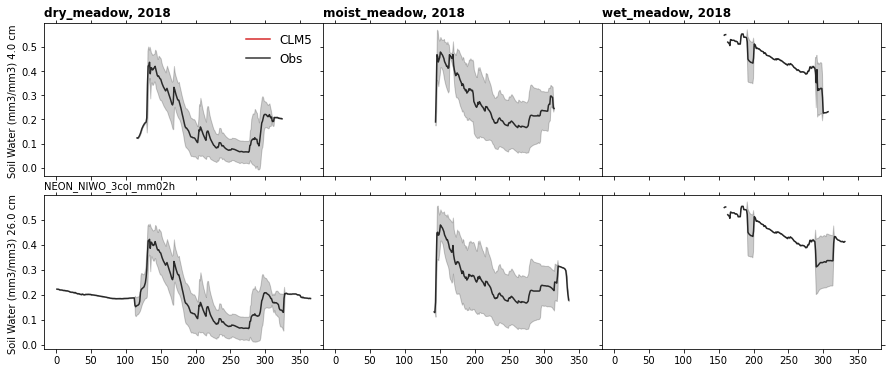

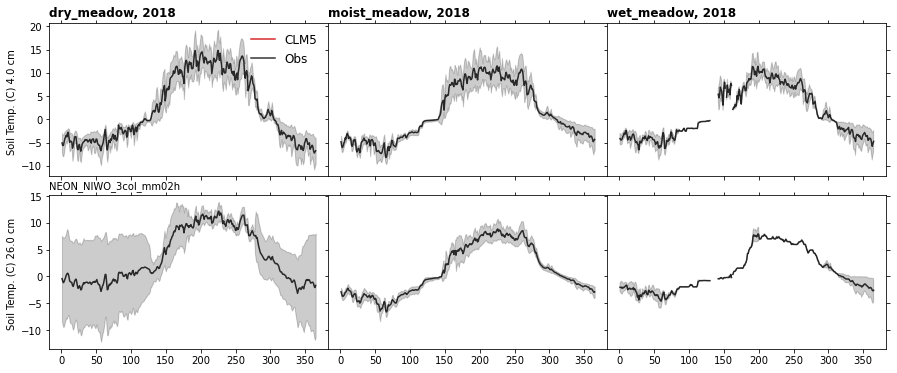

In [58]:
nyear = len(years) 
clmVARS = ['H2OSOI','TSOI']
obsVARSu = ['soilmoisture_upper_avg','soiltemp_upper_avg']
obsVARSl = ['soilmoisture_lower_avg','soiltemp_lower_avg']
plotYear =  2018

for v in range(len(clmVARS)):
    fig, axs = plt.subplots(2, len(Veg), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0.12},
                        figsize=(15,6))    
    for i in range(len(Veg)):
        for j in range(2):
            if i == 0: 
                nlev = 1 #10 cm for fell field
            else: 
                nlev = 1 # 5 cm for sensor network
            if j == 1: nlev = 4

            # Select data to plot    
            x = ds['time.dayofyear'].where(ds['time.year']==plotYear)
            x2 = dsSOI['date.dayofyear'].where(dsSOI['date.year']==plotYear)

            if v == 0:
                y = ds[clmVARS[v]].isel(levsoi=nlev,column=i).where(ds['time.year']==plotYear).groupby(x).mean() 
            else:
                y = ds[clmVARS[v]].isel(levgrnd=nlev,column=i).where(ds['time.year']==plotYear).groupby(x).mean() -273.15
            
            if j == 0: 
                y2 = dsSOI[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear) 
                ySTD = dsSOIstd[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            if j == 1: 
                y2 = dsSOI[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            if v == 0: #convert units for observed soil moisture from % to fraction
                y2 = y2/100
                ySTD = ySTD/100
            x = x.groupby(x).mean()
            
            axs[j,i].plot(x, y, '-',color='tab:red')
            axs[j,i].plot(x2, y2, '-', color='k', alpha=0.8)
            axs[j,i].fill_between(x2, y2-ySTD, y2+ySTD, alpha=0.2,color='k')
            axs[j,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
            axs[j,i].xaxis.set_ticks_position('both')     


            # control titles & axis labels
            # label columns of data with variable names
            depth = str(np.round(ds["levgrnd"].isel(levgrnd=nlev).values * 100,0))
            if j == 0:
                axs[j,i].set_title(fullVeg[i]+", "+str(plotYear),  
                                   loc='left', fontsize='large', fontweight='bold')
                if i == 0 :
                    axs[j,i].legend(('CLM5','Obs'), frameon=False,fontsize='large')
            #if j == 1:
                #axs[j,i].set_title(depth + " cm ", loc='left', fontsize='large', fontweight='bold')
            if i == 0:
                if v == 0:
                    axs[j,i].set_ylabel('Soil Water ('+ds.H2OSOI.attrs['units']+') '+depth+ " cm ");
                else:
                    axs[j,i].set_ylabel('Soil Temp. (C) '+depth+ " cm ");
                if j == 1: #case name for simulations
                    axs[j,i].set_title(case[1],  
                                   loc='left', fontsize='medium')

In [34]:
ds.column

<xarray.DataArray 'column' (column: 3)>
array(['dm', 'mm', 'wm'], dtype='<U2')
Coordinates:
  * column   (column) <U2 'dm' 'mm' 'wm'

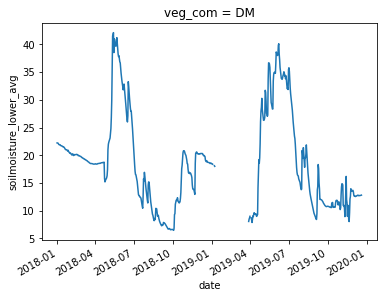

In [35]:
dsSOI.sel(veg_com='DM').where(dsSOI['date.year']>2017).soilmoisture_lower_avg.plot();

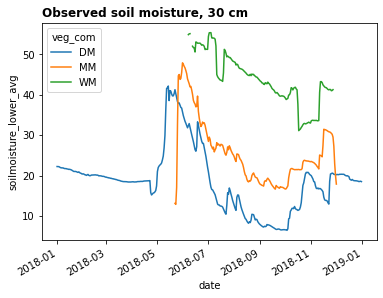

In [36]:
dsSOI.where(dsSOI['date.year']==2018).soilmoisture_lower_avg.plot(hue='veg_com');
plt.title('Observed soil moisture, 30 cm', loc='left', fontsize='large', fontweight='bold');

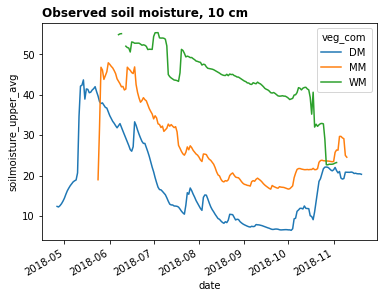

In [37]:
dsSOI.where(dsSOI['date.year']==2018).soilmoisture_upper_avg.plot(hue='veg_com');
plt.title('Observed soil moisture, 10 cm', loc='left', fontsize='large', fontweight='bold');

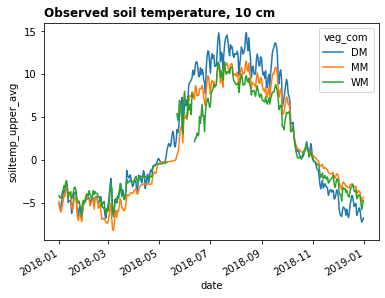

In [38]:
dsSOI.where(dsSOI['date.year']==2018).soiltemp_upper_avg.plot(hue='veg_com');
plt.title('Observed soil temperature, 10 cm', loc='left', fontsize='large', fontweight='bold');

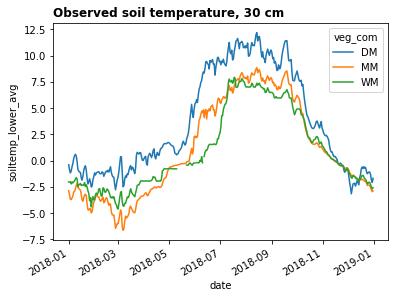

In [39]:
dsSOI.where(dsSOI['date.year']==2018).soiltemp_lower_avg.plot(hue='veg_com');
plt.title('Observed soil temperature, 30 cm', loc='left', fontsize='large', fontweight='bold');

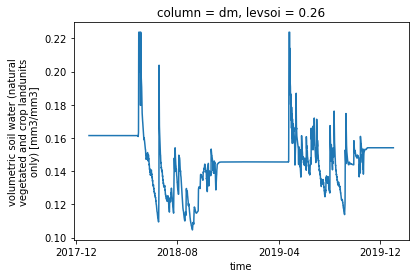

In [40]:
ds.isel(levsoi=4).sel(column='dm').where(ds.H2OSOI['time.year']>2017).H2OSOI.plot(hue='column');

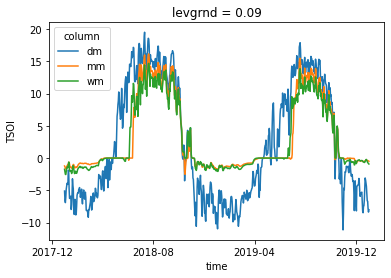

In [41]:
(ds.isel(levgrnd=2).TSOI.resample(time='D').mean('time')-273.15).plot(hue='column');

In [42]:
print(ds.isel(levsoi=4).sel(column='dm').where(ds.H2OSOI['time.year']>2017).H2OSOI.max())

<xarray.DataArray 'H2OSOI' ()>
array(0.2237289)
Coordinates:
    column   <U2 'dm'
    levsoi   float32 0.26


In [43]:
print((ds.isel(levgrnd=2).TSOI.resample(time='D').mean('time')-273.15).max());

<xarray.DataArray 'TSOI' ()>
array(19.49185181)
Coordinates:
    levgrnd  float32 0.09


In [44]:
## Read in Tvan flux tower data

In [45]:
# Niwot LTER simulations
site  = ['NEON_NIWO_3col_dm01_newSoil_trans',
         'NEON_NIWO_3col_dm01_newSoil_trans']
longSite  =  'dry_meadow'
#rollHour = -12  
#case  = ['clm50bgc_NWT_'+site[s] for s in range(len(site))]
#years = range(2008,2020)
#nmon  = 12
OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
OUTdir = OBSdir
#print(OBSfile)


In [46]:
# read in data, remove time shift
dsOBS = utils.time_set_mid(xr.open_mfdataset(OBSfile, decode_times=True, combine='by_coords'), 'time')

In [47]:
# get rid of extra dimensions & coordinates 
dsOBS  = dsOBS.isel(lat=0, lon=0).load()
ds  = ds.isel(lndgrid=0)
ds = ds.shift(time=-1)

In [48]:
# calculate daily means, mask out non-growing season & calculate rolling mean
# super slow when we compute
# no GPP before May 15 & growing season ends Sept 30 (DOY = 135, 273)

temp = dsOBS[['GPP','TBOT']].resample(time='D').mean()   #daily fluxes
temp = temp.where(temp['time.dayofyear']>135,0)  
temp = temp.where(temp['time.dayofyear']<273,0).chunk({'time':100}) 
# set GPP<0 to zero
temp['GPP'] = temp['GPP'].where(temp['GPP']>0,0)
temp['GPP'] = temp['GPP']*3600*24*1e-6*12     # convert flux from umol co2/m2/s to gC/m2/d
temp = temp.rolling(time=10, center=True).mean()#.dropna("time") # rolling mean
#.compute(skipna=True)
print(temp)

<xarray.Dataset>
Dimensions:  (time: 730)
Coordinates:
  * time     (time) object 2018-01-01 00:00:00 ... 2019-12-31 00:00:00
    lat      float64 40.05
    lon      float64 105.6
Data variables:
    GPP      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TBOT     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>


In [49]:
# calculate Rnet from absorbed - reflected radiation
ds['Rnet'] = ds.FSA - ds.FIRA	
ds['Rnet'].attrs['units'] = ds.FSA.attrs['units']
ds['Rnet'].attrs['long_name'] = 'net radiation'

In [50]:
# calculate latent heat flux
ds['EFLX_LH_TOT'] = ds.FCEV + ds.FCTR + ds.FGEV

In [51]:
ds.EFLX_LH_TOT.values

array([[-14.247563 , -17.303074 , -16.392225 ],
       [-13.634696 , -16.114079 , -15.265364 ],
       [-13.155016 , -14.728628 , -14.06445  ],
       ...,
       [  1.4656258,  -8.816145 ,  -8.218404 ],
       [-14.933485 , -20.074318 , -18.461573 ],
       [        nan,         nan,         nan]], dtype=float32)

In [52]:
# convert obs GPP units from umol/m2/s to g/m2/h
# assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600
dsOBS['GPP'].attrs['units'] = 'gC/m2/h'
# convert clm GPP units from g/m2/s to g/m2/h
ds['GPP'] = ds.GPP * 3600
ds['GPP'].attrs['units'] = 'gC/m2/h'

In [53]:
## Make seasonal plots

In [54]:
dsOBS['season'] = dsOBS['time.season']
ds['season'] = ds['time.season']

Var = ['Rnet','FSH','EFLX_LH_TOT','GPP']
Season = ['DJF','MAM','JJA','SON']

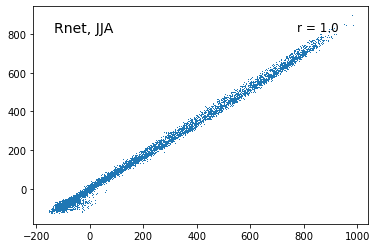

In [55]:

fig, ax = plt.subplots()
x, y = dsOBS[Var[0]].where(dsOBS.season==Season[2]).values,  \
    ds[Var[0]][:,0].where(ds.season==Season[2]).values

ax.plot(x, y,',')
line = mlines.Line2D([x.min(), x.max()], [x.min(), x.max()], color='k')
ax.add_line(line)
ax.text(0.15, 0.90,(Var[0]+', '+Season[2]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, 
        ha='center', va='center', transform=plt.gca().transAxes);

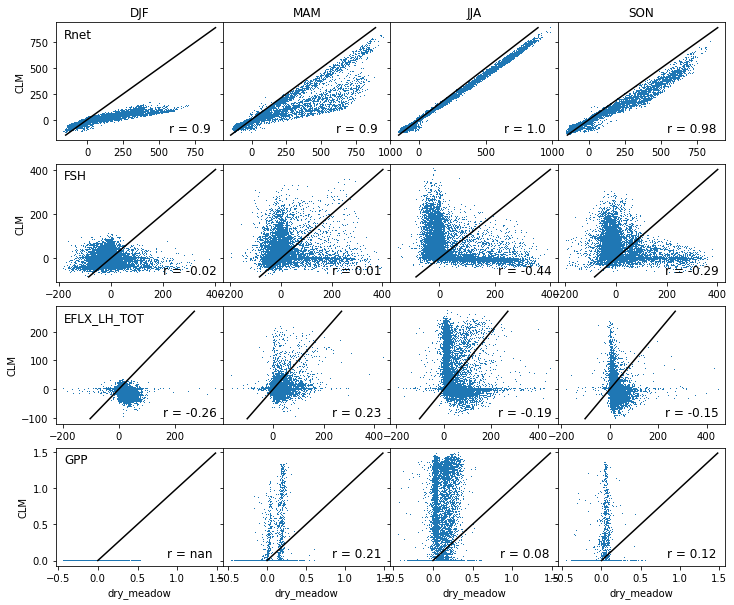

In [56]:
fig, axs = plt.subplots(len(Var), len(Season), sharey='row', #sharey='col',
                        gridspec_kw={'wspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    ymin = ds[Var[v]][:,0].min()
    ymax = ds[Var[v]][:,0].max()
    for i in range(len(Season)):
        x = dsOBS[Var[v]].where(dsOBS.season==Season[i]).values
        y = ds[Var[v]][:,0].where(ds.season==Season[i]).values
        axs[v,i].plot(x, y,',')
        line = mlines.Line2D([ymin, ymax], [ymin, ymax], color='k')
        axs[v,i].add_line(line)

        # add stats
        bad = ~np.logical_or(np.isnan(x), np.isnan(y))
        x = np.compress(bad, x)  
        y = np.compress(bad, y) 
        R, p = stats.pearsonr(x,y)
        R = np.round(R, 2)
        axs[v,i].text(0.8, 0.1,'r = '+str(R),fontsize=12, 
                     ha='center', va='center', transform=axs[v,i].transAxes)

        # control titles & axis labels
        # label colums of data with variable name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            #axs[v,i].text(0.15, 0.90,(Season[i]), fontsize=12, ha='center', va='center', 
            #    transform=axs[v,i].transAxes)
          #  if i == 0:
           #     axs[i, v].set_title(site[0], loc='left', 
            #                        fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel(longSite)
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel('CLM')
            axs[v,i].text(0.05, 0.90,(Var[v]), fontsize=12, ha='left', va='center', 
                transform=axs[v,i].transAxes)

#plt.savefig(OUTdir+site[0]+'_FluxScatter.pdf');

In [57]:
## Plot diel cycle

In [58]:
#Can't groupby hour & minutes, so combine them here
dsOBS['HourMin'] = np.round(dsOBS['time.hour'] + dsOBS['time.minute']/60,1)
ds['HourMin'] = np.round(ds['time.hour'] + ds['time.minute']/60,1)
dsOBS['MonDay'] = np.round(dsOBS['time.month'] + dsOBS['time.day']/100,2)
ds['MonDay'] = np.round(ds['time.month'] + ds['time.day']/100,2)

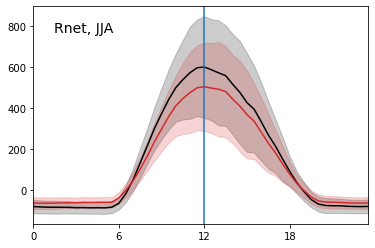

In [59]:
# quick look at one season, variable
v, i = 0, 2
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
clmX = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
clmSD = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);
ax.axvline(x=12)
plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0));

([<matplotlib.axis.XTick at 0x2ba2dd16db50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

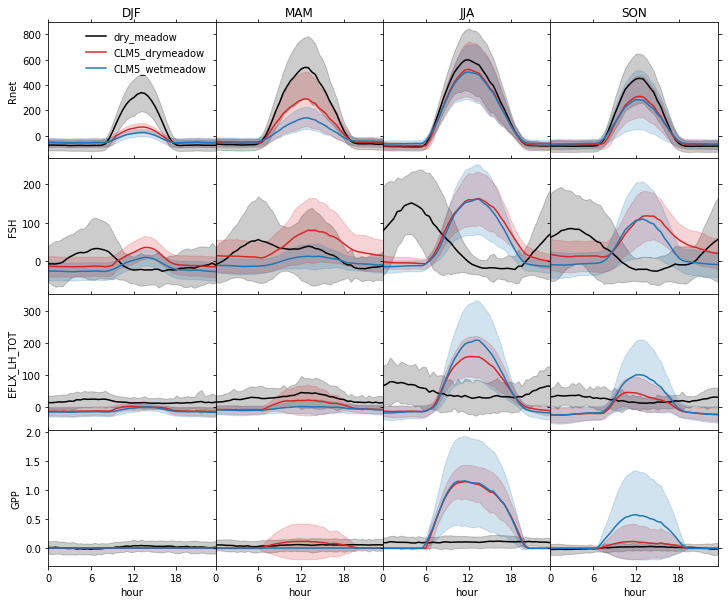

In [60]:
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    xmin = dsOBS[Var[v]].min()
    xmax = dsOBS[Var[v]].max()
    for i in range(len(Season)):
        # maybe use resample, not grouby, 
        # eg da.resample(time='1D').mean()
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmX = ds[Var[v]][:,0].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmSD = ds[Var[v]][:,0].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmX2 = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmSD2 = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].plot(clmX2.HourMin, clmX2, '-', color='tab:blue')
        axs[v,i].fill_between(clmX2.HourMin, clmX2 - clmSD2, clmX2 + clmSD2, alpha=0.2,color='tab:blue')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend([longSite,'CLM5_drymeadow','CLM5_wetmeadow'], frameon=False)
              #  axs[v,i].set_title(site[0], loc='left', 
                   #                 fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 

plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0))
#axs[0,0].legend((network+' '+longSite),'CLM5', frameon=False)

#plt.savefig(OUTdir+site[0]+'_FluxDiel.pdf');

In [61]:
## Plotting mean annual cycles

ConversionError: Failed to convert value(s) to axis units: <xarray.DataArray 'time' (MonDay: 365)>
array([cftime.DatetimeNoLeap(2018, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 2, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 3, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 5, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 6, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 7, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 8, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 9, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 10, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 11, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 12, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 13, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 14, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 17, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 18, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 19, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 1, 20, 0, 0, 0, 0),
...
       cftime.DatetimeNoLeap(2018, 12, 12, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 13, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 14, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 17, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 18, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 19, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 20, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 21, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 22, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 23, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 24, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 25, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 26, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 27, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 28, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 29, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 30, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
    lat      float64 40.05
    lon      float64 105.6
  * MonDay   (MonDay) float64 1.01 1.02 1.03 1.04 ... 12.28 12.29 12.3 12.31

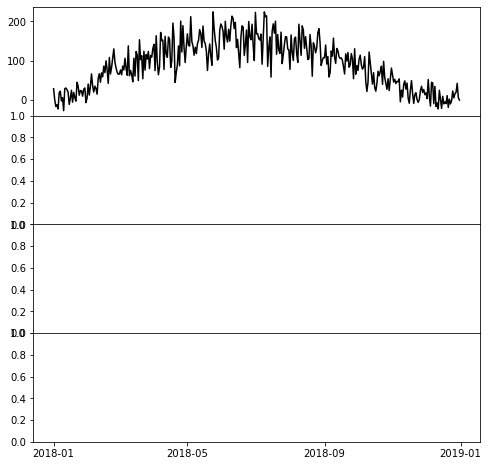

In [62]:
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(len(Var),1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(8,8))
for v in range(len(Var)):
    # using groupby('time.dayofyear') gives too many days in leap year
    # use variable MonDay  instead
    x = dsOBS['time'].groupby(dsOBS.MonDay).min()
    obsX = dsOBS[Var[v]].groupby(dsOBS.MonDay).mean()
    clmX = ds[Var[v]].groupby(dsOBS.MonDay).mean()
    obsSD = dsOBS[Var[v]].groupby(dsOBS.MonDay).std()
    clmSD = ds[Var[v]].groupby(dsOBS.MonDay).std()
        
    axs[v].plot(x, obsX, '-', color='k')
    axs[v].fill_between(x, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
    axs[v].plot(x, clmX, '-',color='tab:red')
    axs[v].fill_between(x, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
    axs[v].set_ylabel(Var[v])       
    axs[v].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
    axs[v].xaxis.set_ticks_position('both')     

    # set  x axis limits
    axs[v].format_xdata = mdates.DateFormatter('%Y-%m-%d')
    axs[v].xaxis.set_major_locator(months)
    axs[v].xaxis.set_major_formatter(months_fmt)
    datemin = np.datetime64(x[0].values, 'm')
    datemax = np.datetime64(x[-1].values, 'm') 
    axs[v].set_xlim(datemin, datemax)

    # control titles & axis labels
    if v == 0: 
        axs[v].set_title(site[0], loc='left', fontsize='x-large', fontweight='bold')

plt.legend([longSite,'CLM5'], frameon=False)

#fig.autofmt_xdate()
plt.savefig(OUTdir+site[0]+'_FluxAnnual.pdf');